# Solving Boundary Value Problems

In addition to finding solutions for an initial value problem (IVP) and estimating unknown parameters, PyGOM also allows users to solve boundary value problems (BVPs) with a little bit of imagination.
Here, we show how a BVP can be solved by treating it as a parameter estimation problem.
Essentially, this is done via a shooting method where the first boundary condition defines the initial condition of an IVP and the second boundary condition is an observation.
We use projectile motion as our example system, which we note is not specific to disease modelling scenarios, but then BVPs are not commonly useful in this domain anyway.

## Problem

Imagine launching a ball straight up into the air from a starting height $y(t=0)=0$. Ignoring air resistance, the ball will be pulled back to it's starting position under gravity.

$$\begin{aligned}
\frac{\mathrm{d}^2 y}{\mathrm{d} t^2}=-g
\end{aligned}$$

where $g$ is acceleration due to gravity. Reducing this equation to two first order ODEs in terms of position and velocity, $v$, yields:

$$\begin{aligned}
\frac{\mathrm{d} y}{\mathrm{d} t}&=v\\
\frac{\mathrm{d} v}{\mathrm{d} t}&=-g
\end{aligned}$$

Let's suppose that the ball lands 3 seconds later (i.e. $y(t=3)=0$).
We will now solve two related BVPs in which the initial speed is unknown and later, the parameter $g$.

## Unknown initial conditions

First, assuming we know that the acceleration due to gravity is $g=-10ms^{-2}$, we must estimate the initial velocity ($v(t=0)$) required to ensure that the ball lands 3 seconds later.
This could be trivially solved via a quick analytical solution of the above equations resulting in $v(0)=15ms^{-1}$.
Here we focus on demonstrating PyGOM's functionality, so this value will instead serve as a target we hope to reproduce.
For some reason, PyGOM will treat model parameters as unknowns and we must specify parameters (in this case $g$) numerically in our equations:

In [1]:
from pygom import Transition, TransitionType, SimulateOde

stateList = ['y', 'v']
paramList=[]

ode1 = Transition(transition_type=TransitionType.ODE, origin='y', equation='v')
ode2 = Transition(transition_type=TransitionType.ODE, origin='v', equation='-10')

model = SimulateOde(stateList, paramList, ode=[ode1, ode2])

We first plot an example trajectory.
Given we know that that the ball will land in 3 seconds if launched with speed $15ms^{-1}$, let's try a faster launch of $20ms^{-1}$ and the ball should still be in the air.

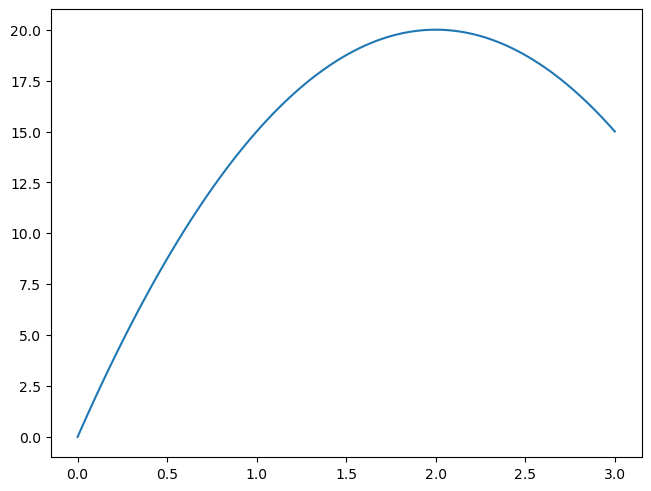

In [2]:
import numpy as np
t = np.linspace(0, 3, 100)             # Time-points at which to find solutions

theta = [0.0, 20.0]                    # Initial position and velocity
model.initial_values = (theta, t[0])   # Initial position, velocity and t[0]
solution = model.solve_determ(t[1::])  # Solve for subsequent timepoints

import matplotlib.pyplot as plt

f, axarr = plt.subplots(layout='constrained')
axarr.plot(t, solution[:,0])
axarr.set_title("Height, y")
axarr.set_xlabel("Time");

Let's now use PyGOM to solve for the initial condition that satisfies the BVP.
We use $20ms^{-1}$ as our initial guess.
It is perhaps a bit inefficient that we have to specify this initial guess twice both in the `theta` parameter and also the initial condition.
We let the solver know which variable we are solving the initial condition for by specifying the `target_state`.

In [3]:
from scipy.optimize import minimize
from pygom import SquareLoss

theta = [20.0]

initialState = [0.0, 20.0]

obj = SquareLoss(theta=theta,
                 ode=model,
                 t0=t[0], x0=initialState,
                 t=t[-1], y=[0],
                 state_name=['y'], target_state=['v'])


We use the {func}`costIV` function to let the solver know we are considering an initial value problem

In [4]:
thetaHat = minimize(fun=obj.costIV, x0=theta)
print(thetaHat)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.987646893079144e-16
        x: [ 1.500e+01]
      nit: 4
      jac: [ 1.122e-10]
 hess_inv: [[ 5.556e-02]]
     nfev: 10
     njev: 5


We see that the target value of $15ms^{-1}$ and when plotting the trajectory below we see that the ball lands after precisely 3 seconds.

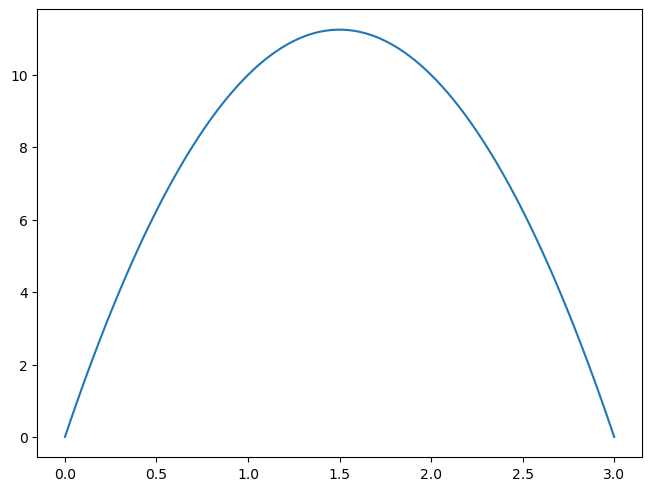

In [5]:
model.initial_values = ([0.0] + thetaHat['x'].tolist(), t[0])

solution = model.integrate(t[1::])

f, axarr = plt.subplots(layout='constrained')
axarr.plot(t, solution[:,0])
axarr.set_title("Height, y")
axarr.set_xlabel("Time");

## Unknown parameters

Now we consider the case where initial conditions are known, but we wish to estimate the unknown parameter $g$ which satisfies the BVP.
Like before, we set up the second boundary condition by pretending that it is an observation.
This time we omit the `target_state` argument to let the solver know that our initial conditions are fixed.
We declare $g$ as a model parameter and then solve as before.

In [6]:
stateList = ['y', 'v']
paramList = ['g']

ode1 = Transition(transition_type=TransitionType.ODE, origin='y', equation='v')
ode2 = Transition(transition_type=TransitionType.ODE, origin='v', equation='-g')

model = SimulateOde(stateList, paramList, ode=[ode1, ode2])

model.parameters = [('g', 5.0)]
theta = [5.0]
initialState = [0.0, 15.0]

t = np.linspace(0, 3, 100)

obj = SquareLoss(theta=theta,
                 ode=model,
                 t0=t[0], x0=initialState,
                 t=t[-1], y=[0],
                 state_name=['y'])

thetaHat = minimize(fun=obj.cost, x0=theta)

We see that the result of $g=10ms^{-2}$ is recovered

In [7]:
print(thetaHat)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.1241808584714344e-15
        x: [ 1.000e+01]
      nit: 4
      jac: [-1.068e-11]
 hess_inv: [[ 2.469e-02]]
     nfev: 10
     njev: 5
